In [21]:
from math import pi
import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [22]:
# # 0-1 50
# np.random.seed(1)
# t_data = np.array([0.0, 0.034482758620689655, 0.06896551724137931, 0.10344827586206896, 0.13793103448275862, 0.1724137931034483, 0.20689655172413793, 0.2413793103448276, 0.27586206896551724, 0.3103448275862069, 0.3448275862068966, 0.3793103448275862, 0.41379310344827586, 0.4482758620689655, 0.4827586206896552, 0.5172413793103449, 0.5517241379310345, 0.5862068965517241, 0.6206896551724138, 0.6551724137931034, 0.6896551724137931, 0.7241379310344828, 0.7586206896551724, 0.7931034482758621, 0.8275862068965517, 0.8620689655172413, 0.896551724137931, 0.9310344827586207, 0.9655172413793104, 1.0])
# delta_real = np.array([-1.0, -0.7580154990560892, -0.5161437433812334, -0.2766048537207341, -0.041802674575424616, 0.1858833970784918, 0.4042480529018171, 0.6114303693104511, 0.8059786334143284, 0.9869146162730239, 1.153731102545101, 1.306287083509873, 1.4447964009065875, 1.569756535500465, 1.6818505996838096, 1.7818607204031671, 1.870659268765975, 1.9491714805132159, 2.01826958097265, 2.078783646966857, 2.131508852922671, 2.177205470871178, 2.2165986052292843, 2.2503340570846433, 2.278941382471026, 2.3029040274854604, 2.3226653388639713, 2.338628563981579, 2.351156850852302, 2.3605517871991557])
# omega_real = np.array([383.9911, 384.01706751326924, 383.9828885247102, 383.8808125971688, 383.7084372056539, 383.4687638670096, 383.1696101373725, 382.8221351721135, 382.4394049518417, 382.03499070163184, 381.62150213890624, 381.2097329925458, 380.80859013730577, 380.4246713030564, 380.062383889052, 379.7245813646966, 379.4126024886706, 379.12660170864535, 378.8658653877571, 378.62924003544396, 378.41531030130216, 378.2223989750864, 378.0485689853088, 377.89187938330747, 377.75062031062566, 377.62313745605, 377.50784802000675, 377.4032407145614, 377.30787576341896, 377.2204251497879])
# print(delta_real.shape)

In [23]:
# 0-0.2 10
t_data = np.linspace(0, 0.2, 10)
print(t_data)
delta_real = [-0.1, -0.08441470937506322, -0.0688037423854327, -0.053222192928088295, -0.03773062311181606, -0.02239321114539309, -0.007274950946655793, 0.007560493585276482, 0.02205150309138274, 0.036141699867384636]
omega_real = [38.39911, 38.40141738637016, 38.40138078522379, 38.39872210442563, 38.39324723381016, 38.3848559990875, 38.37354286389266, 38.35939520883024, 38.34258932254494, 38.323369741858244]


[0.         0.02222222 0.04444444 0.06666667 0.08888889 0.11111111
 0.13333333 0.15555556 0.17777778 0.2       ]


In [24]:
num_qubits=6
dev=qml.device('default.qubit', wires=num_qubits)

# define my own embedding layer
def myembedding(x,wires):
    qml.RY(np.arcsin(x), wires=wires[0])
    qml.RY(2*pi*x, wires=wires[1])


def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubits
    qml.RY(theta[0],wires=0)
    qml.RY(theta[1],wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # print(v)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))



In [25]:
num_layers=4
theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits),requires_grad=True)
print(theta.shape)
# print(theta)
print(qml.draw(quantum_net)(theta,0))


(4, 6)
0: ──RY(0.00)──H─────────RY(5.17)─╭●──H─────────RY(2.72)─╭●──H─────────RY(2.68)─╭●──H───────
1: ──RY(0.00)──RY(1.21)───────────╰X──RY(1.02)───────────╰X──RY(1.64)───────────╰X──RY(5.94)

───RY(6.03)─╭●──H─┤  <Z>
────────────╰X────┤     


In [26]:
# add the classical layer
def classical_quantum_net(theta,w,x):
    r=quantum_net(theta,x)
    return w[0]+w[1]*r+w[2]*r**2
    # return w[0]+w[1]*r

In [27]:
def square_loss(labels,predictions):
    loss=0
    for l,p in zip(labels,predictions):
        loss=loss+(l-p)**2
    loss=loss/len(labels)
    return loss

def cost(theta,w,features,labels):
    preds=[classical_quantum_net(theta,w,x) for x in features]
    return square_loss(labels,preds)

In [28]:
w=np.zeros(3,requires_grad=True)
# w = np.array([ 0.63226731, -0.04043822,  0.10383093])
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)


epochs=100
for e in range(1,epochs+1):
    
    (theta,w,_,_),_cost=opt.step_and_cost(cost,theta,w,t_data,delta_real)
    if e==1 or e%10==0:
        print(f'Epoch: {e} | Cost: {_cost} | w: {w} | theta: {theta}')

Epoch: 1 | Cost: 0.0028520033003422724 | w: [-0.04999974 -0.04999943 -0.0499984 ] | theta: [[5.16865474 1.21236665 3.32614403 3.90967181 3.09213161 2.90752936]
 [2.72276873 1.02005868 5.81930329 2.89104366 4.37870964 3.10636526]
 [2.68352793 1.63642838 0.6833613  6.16623909 1.25874555 3.41304996]
 [6.02648839 5.94093903 4.70984273 1.71834772 5.38054267 3.4660732 ]]
Epoch: 10 | Cost: 0.00027755078459665007 | w: [-0.02500863 -0.18651936 -0.13756623] | theta: [[5.2790846  1.30028571 3.32614403 3.90967181 3.09213161 2.90752936]
 [2.55349605 1.11515593 5.81930329 2.89104366 4.37870964 3.10636526]
 [2.77692374 1.77174154 0.6833613  6.16623909 1.25874555 3.41304996]
 [5.93244053 5.79503826 4.70984273 1.71834772 5.38054267 3.4660732 ]]
Epoch: 20 | Cost: 2.0300373320687903e-05 | w: [-0.04279825 -0.19868577 -0.03171694] | theta: [[5.18724515 1.28277184 3.32614403 3.90967181 3.09213161 2.90752936]
 [2.48772251 1.05700227 5.81930329 2.89104366 4.37870964 3.10636526]
 [2.74540472 1.77957852 0.68336

In [29]:
pred=np.array([classical_quantum_net(theta,w,t) for t in t_data])

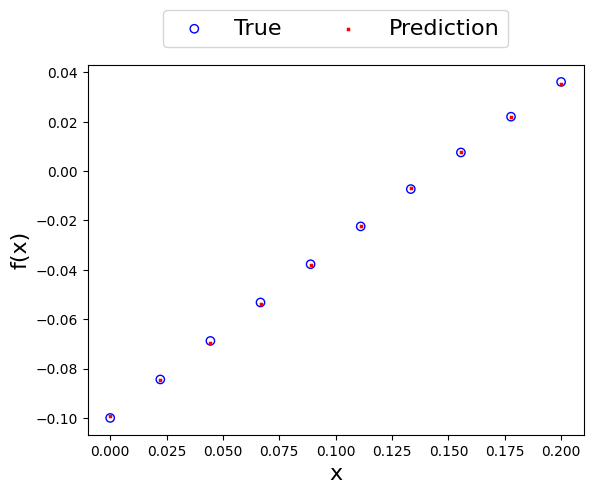

In [30]:
plt.figure()
plt.scatter(t_data,delta_real,facecolors='none', edgecolors='b', label='True')
plt.scatter(t_data,pred, color='red',marker="x",s=4,label='Prediction')
plt.xlabel('x',fontsize=16)
plt.ylabel('f(x)',fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='upper center',bbox_to_anchor=(0.5,1.18),ncol=2,fontsize=16)
# plt.savefig('xsinx_train.png')
plt.show()